In [1]:
import numpy as np
import pylab as pl
import qiskit.tools.jupyter
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit import *
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

In [2]:
backendname_sim = Aer.get_backend('qasm_simulator')

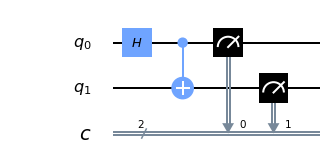

In [3]:
circ = QuantumCircuit(2,2)

circ.h(0)
circ.cx(0,1)
circ.measure(0,0)
circ.measure(1,1)

circ.draw(output='mpl')

In [4]:
circs=[]
for i in range(1024):
    circs.append(circ)

In [5]:
job_clean = execute(circs, backendname_sim, shots=1024)
results_clean=job_clean.result().results
# counts_clean=job.result().get_counts()
# plot_histogram(counts_clean)

In [6]:
# T1 and T2 values for qubits 0-4
T1s = np.random.normal(50e2, 10e2, 5) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e2, 10e2, 5)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(5)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(5):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(5):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'reset', 'cx', 'u3', 'u2']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('reset', [2]), ('reset', [3]), ('reset', [4]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [0, 4]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [1, 4]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [2, 4]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3]), ('cx', [3, 4]), ('cx', [4, 0]), ('cx', [4, 1]), ('cx', [4, 2]), ('cx', [4, 3]), ('cx', [4, 4])]


In [7]:
job_thermal = execute(circs, backendname_sim,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal,shots=1024)
results_thermal=job_thermal.result().results

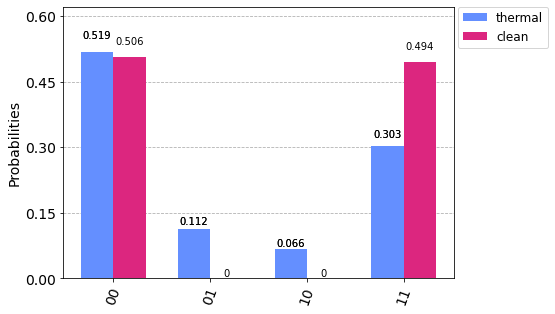

In [8]:
# result_thermal = job.result()
counts_clean = job_clean.result().get_counts(0)
counts_thermal = job_thermal.result().get_counts(0)

# Plot noisy output
plot_histogram([counts_thermal,counts_clean],legend=['thermal','clean'])

In [9]:
numones=np.zeros((2**5,1))
for i in range(2**5):
    numones[i]=bin(i).count("1")


def expectationValue(results):
    #num_qubits = results[0].header.n_qubits
    E=np.zeros((len(results),1))
    for item in range(0,len(results)):
        shots = results[item].shots
        counts = results[item].data.counts
        for key in list(counts.__dict__.keys()):
            c=getattr(counts, key)#number of counts
            E[item] += numones[int(key,0)]*c/shots
    E_conv = np.zeros_like(E)
    for j in range(1,len(results)+1):
        E_conv[j-1] = sum(E[0:j])/j
    return E, E_conv

In [10]:
E_clean, E_conv_clean = expectationValue(job_clean.result().results)
E_thermal, E_conv_thermal = expectationValue(job_thermal.result().results)

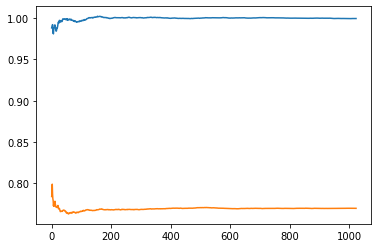

In [11]:
pl.plot(E_conv_clean)
pl.plot(E_conv_thermal)